Running on cpu



/state/partition1/job-65713464/ipykernel_2500738/220923252.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(LSTM_X_CKPT, map_location="cpu")


=== Forcing F=5 | centre traj ID 0 | q=2 (LSTM-X) ===


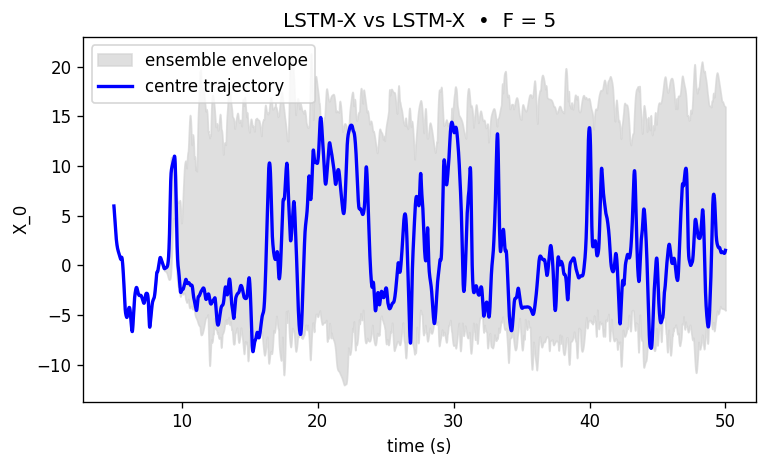

=== Forcing F=10 | centre traj ID 1 | q=2 (LSTM-X) ===


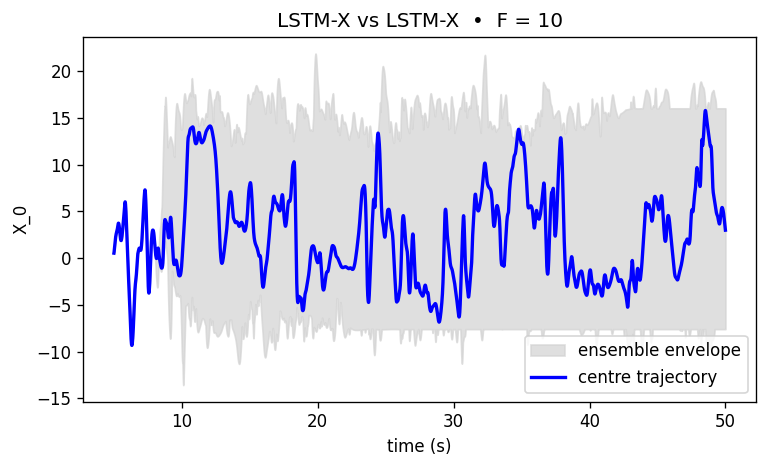

=== Forcing F=15 | centre traj ID 2 | q=2 (LSTM-X) ===


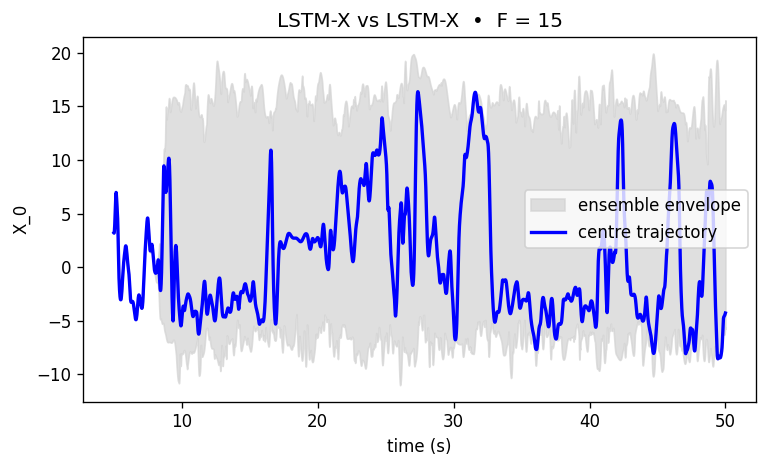


Finished LSTM-X vs LSTM-X divergence plots for all forcings.


In [2]:
#!/usr/bin/env python3
# =============================================================================
#  Multi-forcing divergence / error-growth study (LSTM-X vs LSTM-X only)
#  --------------------------------------------------------------------
#  • Dataset           : Lorenz-96, forcings F = 5, 10, 15  (multiple-implicit)
#  • Error model       : ΔX-LSTM-X (direct next-state in z; no AB)
#  • Scenario          : LSTM-X vs LSTM-X (ensemble envelope) for each F
#  • Ensemble          : K = 50, Gaussian perturbations with RMS ε at t0
#  • Output            : 3 plots (one per F) showing the spread of X_0(t)
#
#  Notes:
#    - Uses the *first* shifted trajectory for each F (same index choice as your
#      earlier multi-forcing divergence script).
#    - Window seeding: initial q frames = duplicates of the starting state in z.
#      (Kept consistent with your ΔX-LSTM divergence setup.)
# =============================================================================

import os, math, warnings
import numpy as np
import matplotlib.pyplot as plt
import torch

# ────────────────────────────────────────────────────────────────────────────
# 0) House-keeping and globals
# ────────────────────────────────────────────────────────────────────────────
warnings.filterwarnings("ignore", category=UserWarning)
torch.set_printoptions(sci_mode=False, linewidth=120)

# Simulation window & ensemble params
DT        = 0.005
T0        = 5.0
T_END     = 50.0
EPS       = 1e-5
K         = 50
RADIUS    = EPS * math.sqrt(5/3)   # converts ε-sphere to ε-RMSE
STATE_TO_PLOT = 0                  # plot X_0(t)

# Forcings to study (must exist in the shifted file)
FORCINGS = [5.0, 10.0, 15.0]

# Files (multiple-implicit)
SHIFTED_FILE = "shifted_force5_10_15_data.npz"                # unseen trajectories
TRAIN_FILE   = "force_5_10_15_data.npz"                       # for μ / σ fallback
LSTM_X_CKPT  = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"

# ────────────────────────────────────────────────────────────────────────────
# 1) Device
# ────────────────────────────────────────────────────────────────────────────
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE.type == "cpu":
    torch.set_num_threads(min(14, os.cpu_count() or 1))
print(f"Running on {DEVICE}\n")

# ────────────────────────────────────────────────────────────────────────────
# 2) Lorenz-96 (Torch; for possible future use, not needed by LSTM-X directly)
# ────────────────────────────────────────────────────────────────────────────
def l96_rhs_t(x, F):
    return (torch.roll(x,-1,-1) - torch.roll(x,2,-1)) * torch.roll(x,1,-1) - x + F

def rk4_step_t(x, dt, F):
    k1 = l96_rhs_t(x, F)
    k2 = l96_rhs_t(x + 0.5*dt*k1, F)
    k3 = l96_rhs_t(x + 0.5*dt*k2, F)
    k4 = l96_rhs_t(x + dt*k3,    F)
    return x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

# ────────────────────────────────────────────────────────────────────────────
# 3) Load data & time axes
# ────────────────────────────────────────────────────────────────────────────
shifted = np.load(SHIFTED_FILE)
X_shift = shifted["X"].astype(np.float32)   # (traj, step, 36)
F_shift = shifted["F"].astype(np.float32)   # (traj,)

steps_t0   = int(round(T0   / DT))
steps_tend = int(round(T_END/DT))
n_steps    = steps_tend - steps_t0
t_vec      = np.arange(n_steps + 1, dtype=np.float32) * DT + T0

# Fallback μ/σ from training set
train_all = np.load(TRAIN_FILE)["X"].astype(np.float32).reshape(-1, 36)
MU_FALL = torch.tensor(train_all.mean(0)).float().to(DEVICE)
SD_FALL = torch.tensor(train_all.std (0) + 1e-8).float().to(DEVICE)

# ────────────────────────────────────────────────────────────────────────────
# 4) LSTM-X model (multiple-implicit)
# ────────────────────────────────────────────────────────────────────────────
def find_state_dict(obj):
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, (torch.Tensor, np.ndarray)) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = find_state_dict(v)
                if sd is not None:
                    return sd
    return None

def parse_q_from_name(path: str):
    import os, re
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

class LSTM_X(torch.nn.Module):
    """One-layer LSTM that outputs next-state X̂ (normalised)."""
    def __init__(self, hidden=70, n=36):
        super().__init__()
        self.lstm = torch.nn.LSTM(n, hidden, batch_first=True)
        self.head = torch.nn.Linear(hidden, n)
    def forward(self, w):              # w: (B, q, N) in z-space
        y,_ = self.lstm(w)
        return self.head(y[:, -1])     # (B, N) → X̂_norm

# Load checkpoint
raw = torch.load(LSTM_X_CKPT, map_location="cpu")
sd  = find_state_dict(raw)
if sd is None:
    raise RuntimeError(f"Could not find state_dict in {LSTM_X_CKPT}")
hidden = int(raw.get("hidden_size", 70)) if isinstance(raw, dict) else 70
q_lx   = int(raw.get("lookback")) if isinstance(raw, dict) and raw.get("lookback") is not None else parse_q_from_name(LSTM_X_CKPT)
if q_lx is None:
    raise ValueError("Lookback q not found. Encode in ckpt as 'lookback' or filename suffix _q{q}.pt")

net_lx = LSTM_X(hidden, n=36).to(DEVICE).eval()
net_lx.load_state_dict(sd)

mu_lx = torch.tensor((raw.get("mean", MU_FALL.cpu().numpy())).astype(np.float32)).to(DEVICE) if isinstance(raw, dict) else MU_FALL
sd_lx = torch.tensor((raw.get("std",  SD_FALL.cpu().numpy())).astype(np.float32)).to(DEVICE) if isinstance(raw, dict) else SD_FALL

# ────────────────────────────────────────────────────────────────────────────
# 5) Rollout helper (LSTM-X)
# ────────────────────────────────────────────────────────────────────────────
@torch.no_grad()
def rollout_lstm_x(x0_phys: np.ndarray) -> np.ndarray:
    """
    LSTM-X: direct next-state in z, autoregressive, sliding window of length q_lx.
    Initial window = q_lx duplicates of x0 (normalised), for consistency with the
    ΔX-LSTM divergence setup you used earlier.
    """
    out = np.empty((n_steps + 1, 36), np.float32)
    out[0] = x0_phys

    # Build initial window in z-space
    x0_z   = (torch.from_numpy(x0_phys).float().to(DEVICE) - mu_lx) / sd_lx
    win    = x0_z.repeat(q_lx, 1)            # (q, 36)
    win    = win.unsqueeze(0)                # (1, q, 36)

    for s in range(1, n_steps + 1):
        y_next_z = net_lx(win)               # (1, 36)  → X̂_norm
        # Slide the window with the predicted next state
        win = torch.cat([win[:, 1:, :], y_next_z.unsqueeze(1)], dim=1)
        # Back to physical space and store
        out[s] = (y_next_z.squeeze(0) * sd_lx + mu_lx).detach().cpu().numpy()
    return out

# ────────────────────────────────────────────────────────────────────────────
# 6) Main loop: LSTM-X vs LSTM-X envelopes for F = 5,10,15
# ────────────────────────────────────────────────────────────────────────────
for F in FORCINGS:
    # Grab first trajectory with this forcing (same index convention as before)
    idxs = np.where(F_shift == F)[0]
    if idxs.size == 0:
        raise RuntimeError(f"No trajectory with F = {F} in {SHIFTED_FILE}")
    centre_id = idxs[0]
    x0_centre = X_shift[centre_id, steps_t0].copy()

    # Build K-member ensemble around x0 at t0
    rng = np.random.default_rng(0)  # reproducible
    ensemble0 = x0_centre + RADIUS * rng.standard_normal((K, 36)).astype(np.float32)

    print(f"=== Forcing F={F:g} | centre traj ID {centre_id} | q={q_lx} (LSTM-X) ===")

    # Roll out centre and ensemble with LSTM-X
    centre_traj = rollout_lstm_x(x0_centre)
    ens_trajs   = np.stack([rollout_lstm_x(e.copy()) for e in ensemble0], axis=0)  # (K, T+1, 36)

    # Envelope over centre+ensemble for component 0
    all_stack = np.concatenate([centre_traj[None, ...], ens_trajs], axis=0)  # (K+1, T+1, 36)
    y_min = all_stack[:, :, STATE_TO_PLOT].min(axis=0)
    y_max = all_stack[:, :, STATE_TO_PLOT].max(axis=0)

    # Plot
    plt.figure(figsize=(6.5, 4.0), dpi=120)
    plt.fill_between(t_vec, y_min, y_max, color="lightgrey", alpha=0.72, label="ensemble envelope")
    plt.plot(t_vec, centre_traj[:, STATE_TO_PLOT], lw=2.0, color="blue", label="centre trajectory")
    plt.xlabel("time (s)")
    plt.ylabel(f"X_{STATE_TO_PLOT}")
    plt.title(f"LSTM-X vs LSTM-X  •  F = {F:g}")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nFinished LSTM-X vs LSTM-X divergence plots for all forcings.")
